## CIFAR-10

In [1]:
import numpy as np
from torchvision import transforms
from torchvision.datasets import CIFAR10

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
cifar10_images = [(255 * image.numpy()).astype(np.uint8) for image, _ in train_dataset]
# np.in1d trick - https://stackoverflow.com/a/16216866
cifar10_images_bytes = np.array([cifar10_image.tobytes() for cifar10_image in cifar10_images])
cifar10_labels = [label for _, label in train_dataset]

Files already downloaded and verified


## Cui et al. (ClassBalancedLoss)

In [2]:
import gdown
import zipfile
import os

if not os.path.exists("data/tfrecords/"):
    # Download from Google Drive
    # https://github.com/richardaecn/class-balanced-loss/blob/master/README.md#datasets
    url = "https://drive.google.com/uc?id=1NY3lWYRfsTWfsjFPxJUlPumy-WFeD7zK"
    output = "tfrecords.zip"
    gdown.download(url, output, quiet=False)

    # Unzip to `tfrecords/data/`
    with zipfile.ZipFile("tfrecords.zip", "r") as zip_ref:
        zip_ref.extractall("tfrecords")

    # Rename directories and remove zip file
    os.makedirs("data/", exist_ok=True)
    os.rename("tfrecords/data/", "data/tfrecords/")
    os.remove("tfrecords.zip")
    os.rmdir("tfrecords/")

In [3]:
import tensorflow as tf

filenames = ["data/tfrecords/cifar-10-data-im-0.01/train.tfrecords"]
raw_dataset = tf.data.TFRecordDataset(filenames)

2023-02-10 21:06:30.723997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 21:06:31.388715: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-10 21:06:31.388779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-10 21:06:31.388787: W tensorfl

In [4]:
images, labels = [], []
for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    image_bytes = example.features.feature['image'].bytes_list.value
    image_tf = tf.io.decode_raw(image_bytes, tf.uint8)
    image = tf.reshape(image_tf, [1, 3, 32, 32]).numpy()
    images.extend(image)
    label = example.features.feature['label'].int64_list.value
    labels.extend(label)

cui_images = np.array(images)
cui_labels = np.array(labels)
cui_images.shape, cui_labels.shape

((12406, 3, 32, 32), (12406,))

In [5]:
cui_images_bytes = np.array([cui_image.tobytes() for cui_image in cui_images])
cui_intersection = np.in1d(cifar10_images_bytes, cui_images_bytes)
cui_indices = np.where(cui_intersection)[0]

In [6]:
with open("cifar10ir100_indices_cui.txt", "w") as f:
    for i in cui_indices:
        f.write(f"{i}\n")

## M2m

In [7]:
valid_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified


In [8]:
from m2m_data_loader import make_longtailed_imb, get_imbalanced

N_CLASSES = 10
N_SAMPLES = 5000
N_SAMPLES_PER_CLASS_BASE = [int(N_SAMPLES)] * N_CLASSES
N_SAMPLES_PER_CLASS_BASE = make_longtailed_imb(N_SAMPLES, N_CLASSES, 100)
N_SAMPLES_PER_CLASS_BASE = tuple(N_SAMPLES_PER_CLASS_BASE)
print(N_SAMPLES_PER_CLASS_BASE)

train_default_loader, valid_loader, test_loader = get_imbalanced(train_dataset, valid_dataset, N_SAMPLES_PER_CLASS_BASE)

0.599484250318941
(5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50)


In [9]:
import numpy as np

m2m_images = []
m2m_labels = []
for images, labels in train_default_loader:
    m2m_images.extend(images.numpy())
    m2m_labels.extend(labels.numpy())
m2m_images = np.array(m2m_images)
m2m_labels = np.array(m2m_labels)
m2m_images.shape, m2m_labels.shape

((12406, 3, 32, 32), (12406,))

In [10]:
m2m_images = (255*m2m_images).astype(np.uint8)

In [11]:
m2m_images_bytes = np.array([m2m_image.tobytes() for m2m_image in m2m_images])
m2m_intersection = np.in1d(cifar10_images_bytes, m2m_images_bytes)
m2m_indices = np.where(m2m_intersection)[0]

In [12]:
with open("cifar10ir100_indices_m2m.txt", "w") as f:
    for i in m2m_indices:
        f.write(f"{i}\n")

## LDAM-DRW

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [14]:
ldam_train_dataset = IMBALANCECIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [15]:
import numpy as np

ldam_images = [(255 * image.numpy()).astype(np.uint8) for image, _ in ldam_train_dataset]
ldam_labels = [label for _, label in ldam_train_dataset]

In [16]:
# np.in1d trick - https://stackoverflow.com/a/16216866
ldam_images_bytes = np.array([ldam_image.tobytes() for ldam_image in ldam_images])
ldam_intersection = np.in1d(cifar10_images_bytes, ldam_images_bytes)
ldam_indices = np.where(ldam_intersection)[0]

In [17]:
with open("cifar10ir100_indices_ldam.txt", "w") as f:
    for i in ldam_indices:
        f.write(f"{i}\n")

## Comparison

In [18]:
len(set(ldam_indices) - set(m2m_indices))

4610

In [19]:
len(set(cui_indices) - set(m2m_indices))

4615

In [20]:
len(set(ldam_indices) - set(cui_indices))

4548

## Unique Images

In [21]:
import matplotlib.pyplot as plt

def plot_chw(image, save_filepath):
    image_hwc = np.transpose(image, (1, 2, 0))
    plt.axis("off")
    plt.imshow(image_hwc)
    plt.savefig(save_filepath, bbox_inches="tight")


41215 1


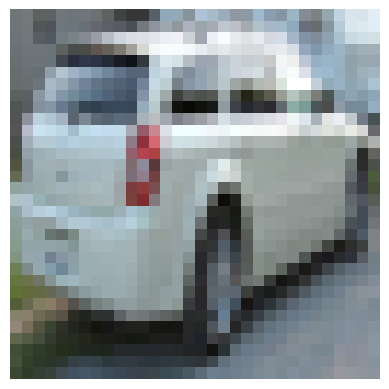

In [22]:
only_ldam_indices = list(set(ldam_indices) - set(m2m_indices) - set(cui_indices))
print(only_ldam_indices[100], cifar10_labels[only_ldam_indices[100]])
plot_chw(cifar10_images[only_ldam_indices[100]], "only_ldam.png")

126 1


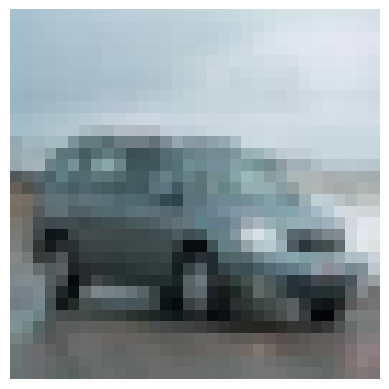

In [23]:
only_m2m_indices = list(set(m2m_indices) - set(ldam_indices) - set(cui_indices))
print(only_m2m_indices[100], cifar10_labels[only_m2m_indices[100]])
plot_chw(cifar10_images[only_m2m_indices[100]], "only_m2m.png")

49186 1


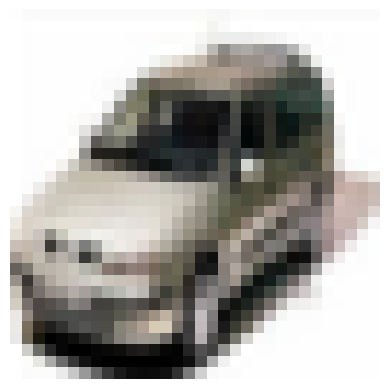

In [24]:
only_cui_indices = list(set(cui_indices) - set(ldam_indices) - set(m2m_indices))
print(only_cui_indices[13], cifar10_labels[only_cui_indices[13]])
plot_chw(cifar10_images[only_cui_indices[13]], "only_cui.png")

## Venn Diagram

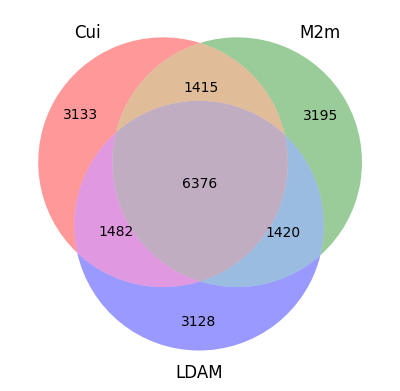

In [26]:
from matplotlib_venn import venn3

venn3([set(cui_indices), set(m2m_indices), set(ldam_indices)], ("Cui", "M2m", "LDAM"))
plt.savefig("venn.png")